In [1]:
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [237]:
# Load the data
cleaned_data = pd.read_csv("cleaned_data.csv")
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])


# Calculate the MACD line, Signal line, and MACD Histogram
macd = ta.macd(cleaned_data['Adj Close'], fast=12, slow=26, signal=9)
cleaned_data['MACD'] = pd.to_numeric(macd['MACD_12_26_9'], errors='coerce')
cleaned_data['MACD_Signal'] = pd.to_numeric(macd['MACDs_12_26_9'], errors='coerce')
cleaned_data['MACD_Histogram'] = pd.to_numeric(macd['MACDh_12_26_9'], errors='coerce')

# Ensure MACD Histogram column contains numeric data before calculating Bollinger Bands
if cleaned_data['MACD_Histogram'].dtype != 'float64':
    cleaned_data['MACD_Histogram'] = pd.to_numeric(cleaned_data['MACD_Histogram'], errors='coerce')

# Calculate 10-day Bollinger Bands on MACD Histogram with 2 standard deviations
bollinger_band = ta.bbands(cleaned_data['MACD_Histogram'], length=10, std=2)
cleaned_data['Lower_BB'] = pd.to_numeric(bollinger_band['BBL_10_2.0'], errors='coerce')
cleaned_data['Upper_BB'] = pd.to_numeric(bollinger_band['BBU_10_2.0'], errors='coerce')

# Define buy/sell signals based on Bollinger Bands and MACD Histogram
cleaned_data['Signal'] = None
cleaned_data.loc[cleaned_data['MACD_Histogram'] < cleaned_data['Lower_BB'], 'Signal'] = 'Buy'
cleaned_data.loc[cleaned_data['MACD_Histogram'] > cleaned_data['Upper_BB'], 'Signal'] = 'Sell'


In [239]:
# Initialize variables for backtest
initial_cash = 100_000
cash = initial_cash
shares = 0
equity = initial_cash
equity_curve = []
total_trades = 0
risk_percent = 0.02
stop_loss_percent = 0.02
buy_signals = cleaned_data[cleaned_data['Signal'] == 'Buy'].index
sell_signals = cleaned_data[cleaned_data['Signal'] == 'Sell'].index
winning_trades = 0
losing_trades = 0
trade_profits = []
started = False

In [240]:
# Backtesting loop with profit tracking for each trade
for i, row in cleaned_data.iterrows():
    # Start with Buy signal
    if not started and i in buy_signals:
        position_risk = equity * risk_percent
        stop_loss = row['Adj Close'] * (1 - stop_loss_percent)
        risk_per_share = row['Adj Close'] - stop_loss
        shares_to_buy = int(position_risk // risk_per_share)
        
        if cash >= shares_to_buy * row['Adj Close']:
            shares += shares_to_buy
            cash -= shares_to_buy * row['Adj Close']
            entry_price = row['Adj Close']  # Track entry price
            total_trades += 1
            started = True

    elif started:
        # Buy signal
        if i in buy_signals and shares == 0:
            position_risk = equity * risk_percent
            stop_loss = row['Adj Close'] * (1 - stop_loss_percent)
            risk_per_share = row['Adj Close'] - stop_loss
            shares_to_buy = int(position_risk // risk_per_share)

            if cash >= shares_to_buy * row['Adj Close']:
                shares += shares_to_buy
                cash -= shares_to_buy * row['Adj Close']
                entry_price = row['Adj Close']  # Track entry price for profit calculation
                total_trades += 1

        # Sell signal
        elif i in sell_signals and shares > 0:
            # Calculate profit/loss for the trade
            profit = (row['Adj Close'] - entry_price) * shares
            trade_profits.append(profit)
            
            # Update winning or losing trades
            if profit > 0:
                winning_trades += 1
            else:
                losing_trades += 1

            # Sell all shares and update cash
            cash += shares * row['Adj Close']
            shares = 0
            total_trades += 1

    # Update equity and equity curve
    equity = cash + shares * row['Adj Close']
    equity_curve.append(equity)

In [241]:
# Add equity curve and calculate performance metrics
cleaned_data['Equity'] = equity_curve
final_equity = equity_curve[-1]
total_return = (final_equity - initial_cash) / initial_cash
cagr = (final_equity / initial_cash) ** (1 / (len(cleaned_data) / 252)) - 1

# Calculate max drawdown
running_max = np.maximum.accumulate(equity_curve)
drawdown = (equity_curve - running_max) / running_max
max_drawdown = drawdown.min()

# Calculate time in market
time_in_market = len(cleaned_data[(cleaned_data['Signal'] == 'Buy') | (cleaned_data['Signal'] == 'Sell')]) / len(cleaned_data)

# Calculate daily returns and Sharpe ratio
daily_returns = pd.Series(equity_curve).pct_change().dropna()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()

# Buy-and-hold strategy for comparison
initial_price = cleaned_data['Adj Close'].iloc[0]
cleaned_data['Buy_and_Hold'] = initial_cash * (cleaned_data['Adj Close'] / initial_price)

# Additional metrics: win ratio, gain per trade, Sortino ratio
winning_trades = sum(1 for profit in trade_profits if profit > 0)
losing_trades = sum(1 for profit in trade_profits if profit <= 0)
total_trades = winning_trades + losing_trades
win_ratio = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
gain_per_trade = np.mean(trade_profits) if trade_profits else 0

# Sortino Ratio calculation (only downside deviation)
negative_returns = daily_returns[daily_returns < 0]
downside_std = negative_returns.std()
sortino_ratio = np.sqrt(252) * daily_returns.mean() / downside_std if downside_std > 0 else 0





In [230]:
# Compile metrics dictionary
metrics = {
    'Final Equity': final_equity,
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown (%)': max_drawdown * 100,
    'Total Trades': total_trades,
    'Winning Trades': winning_trades,
    'Losing Trades': losing_trades,
    'Win Ratio (%)': win_ratio,
    'Gain per Trade': gain_per_trade,
    'Total Return (%)': total_return * 100,
    'CAGR (%)': cagr * 100,
    'Time in Market (%)': time_in_market * 100
}

In [242]:
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

Final Equity: 1142012.87
Sharpe Ratio: 0.59
Sortino Ratio: 0.59
Max Drawdown (%): -44.67
Total Trades: 130.00
Winning Trades: 91.00
Losing Trades: 39.00
Win Ratio (%): 70.00
Gain per Trade: 8015.48
Total Return (%): 1042.01
CAGR (%): 8.37
Time in Market (%): 11.34


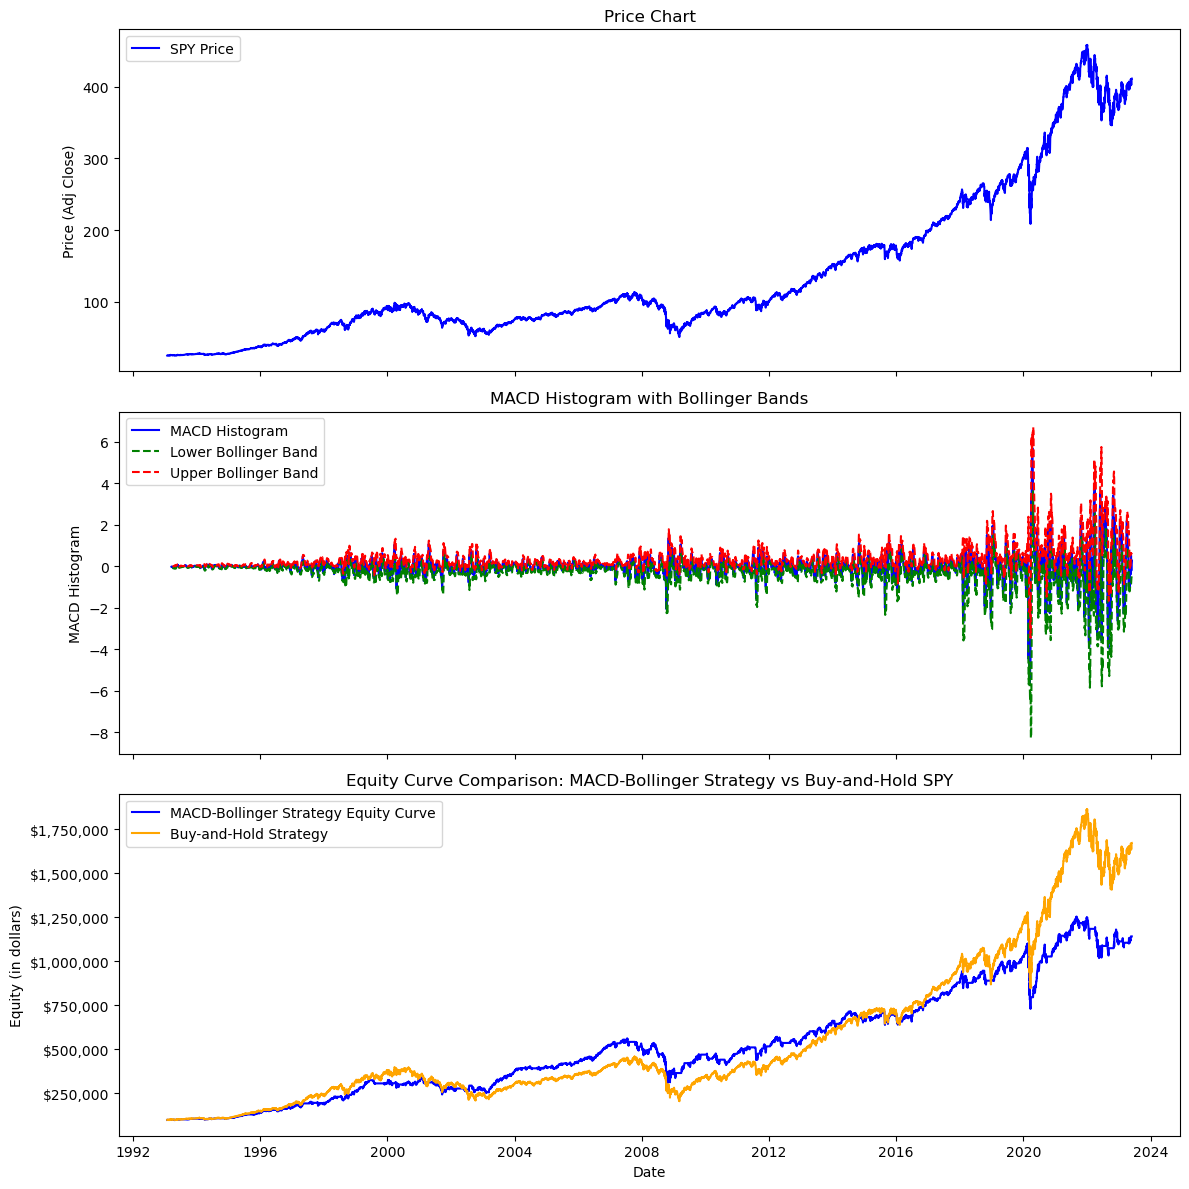

In [244]:
# Buy/sell signal data for plotting
buy_signals_plot = cleaned_data[cleaned_data['Signal'] == 'Buy']
sell_signals_plot = cleaned_data[cleaned_data['Signal'] == 'Sell']

# Plot all three charts (Price, MACD Histogram with Bollinger Bands, and Equity Curves)
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 1. Price chart (without buy and sell signals)
axs[0].plot(cleaned_data['Date'],
            cleaned_data['Adj Close'],
            label='SPY Price',
            color='blue')
axs[0].set_ylabel('Price (Adj Close)')
axs[0].set_title('Price Chart')
axs[0].legend()

# 2. MACD Histogram with Bollinger Bands
axs[1].plot(cleaned_data['Date'],
            cleaned_data['MACD_Histogram'],
            label='MACD Histogram',
            color='blue')
axs[1].plot(cleaned_data['Date'], 
            cleaned_data['Lower_BB'], 
            linestyle='--', color='green', 
            label='Lower Bollinger Band')
axs[1].plot(cleaned_data['Date'], 
            cleaned_data['Upper_BB'], 
            linestyle='--', color='red', 
            label='Upper Bollinger Band')
axs[1].set_ylabel('MACD Histogram')
axs[1].set_title('MACD Histogram with Bollinger Bands')
axs[1].legend()

# 3. Equity curve comparison: MACD-Bollinger strategy vs. buy-and-hold
axs[2].plot(cleaned_data['Date'],
            cleaned_data['Equity'],
            label='MACD-Bollinger Strategy Equity Curve',
            color='blue')
axs[2].plot(cleaned_data['Date'],
            cleaned_data['Buy_and_Hold'],
            label='Buy-and-Hold Strategy',
            color='orange')

# Format y-axis as dollar amounts and set x-axis ticks to every year
axs[2].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
axs[2].set_ylabel('Equity (in dollars)')
axs[2].set_title('Equity Curve Comparison: MACD-Bollinger Strategy vs Buy-and-Hold SPY')
axs[2].legend()

# Set common labels
axs[2].set_xlabel('Date')

# Auto-adjust layout
plt.tight_layout()

# Save the figure as a PDF (ensure this happens before plt.show())
plt.savefig('reproduced_strategy_backtest.pdf', format='pdf')

# Display the plot
plt.show()